In [5]:
import numpy as np
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.stats as st
from mpl_toolkits import mplot3d

import pyshtools as sh

In [6]:
pts = np.genfromtxt('llTessel')
lat = pts[:, 0]
lon = pts[:, 1]

Plan:
    
    1. Get igrf from shtools
    
    2. Sample those points on the grid
    
    3. Try to convert back and forth
    
1. Easy


2. expand.MakeGridPoint() samples from an existing SH function and can be called using attributes of an sh class


3. expand.SHExpandLSQ() will create an SH model from a grid of irregularly sampled points 
        Only returns the coefficients and the RMS misfit
        sh.SHMagCoeffs.from_array(coeffs, r0) will make a new class from the coefficients

In [23]:
igrfSH = sh.SHMagCoeffs.from_file('igrf13coeffs.txt', format='igrf', r0=3500e3, year=2020)
igrfG = igrfSH.expand(lmax=700)

In [24]:
igrfSH.coeffs.shape

(2, 14, 14)

In [25]:
# It looks like there is no way to expand a grid in terms of its values other than to export the grid as netCDf or text file
# MakeGridPoint allows for sampling a SH model

In [26]:
help(sh.expand.MakeGridPoint)

Help on vectorize in module numpy:

<numpy.vectorize object>
    Evaluate a real function expressed in real spherical harmonics at a set of
    points.
    
    Usage
    -----
    value = MakeGridPoint (cilm, lat, lon, [lmax, norm, csphase, dealloc])
    
    Returns
    -------
    value : float, ndarray
        Value of the function at (lat, lon).
    
    Parameters
    ----------
    cilm : float, dimension (2, lmaxin+1, lmaxin+1)
        The real spherical harmonic coefficients of the function. The coefficients
        C0lm and C1lm refer to the cosine (Clm) and sine (Slm) coefficients,
        respectively, with Clm=cilm[0,1,m] and Slm=cilm[1,l,m].
    lat : float, array_like
        The geocentric latitude of the point in degrees.
    lon : float, array_like
        The longitude of the point in degrees.
    lmax : integer, array_like, optional, default = lmaxin
        The maximum spherical harmonic degree used in evaluating the function.
    norm : integer, array_like, option

In [39]:
igrfSample = sh.expand.MakeGridPoint(igrfSH.coeffs, lat, lon, igrfSH.lmax, 2, igrfSH.csphase, r0=3500e3)

TypeError: 'r0' is an invalid keyword argument for _SHTOOLS.MakeGridPoint()

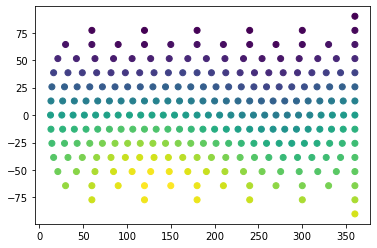

In [38]:
lon[lon <= 0] += 360
plt.scatter(lon, lat, c=igrfSample)

/Users/ccroberts/opt/anaconda3/envs/pyshtools/lib/python3.9/site-packages/pyshtools/shclasses/shgrid.py:1395: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x216 with 2 Axes>, <AxesSubplot:>)

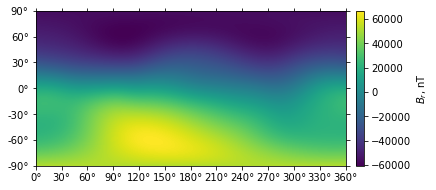

In [29]:
igrfG.plot_rad()
#plt.scatter(lon, lat, c='white')

In [30]:
help(sh.expand.SHExpandLSQ)

Help on function wrapped_func in module pyshtools.shtools:

wrapped_func(*args, **kwargs)
    Expand a set of irregularly sampled data points into spherical harmonics using a
    least squares inversion.
    
    Usage
    -----
    cilm, chi2 = SHExpandLSQ (d, lat, lon, lmax, [norm,  csphase])
    
    Returns
    -------
    cilm : float, dimension (2, lmax+1, lmax+1)
        The real spherical harmonic coefficients of the function. The coefficients
        C0lm and C1lm refer to the cosine (Clm) and sine (Slm) coefficients,
        respectively, with Clm=cilm[0,l,m] and Slm=cilm[1,l,m].
    chi2 : float
        The residual sum of squares misfit for an overdetermined inversion.
    
    Parameters
    ----------
    d : float, dimension (nmax)
        The value of the function at the coordinates (lat, lon).
    lat : float, dimension (nmax)
        The latitude in DEGREES corresponding to the value in d.
    lon : float, dimension (nmax)
        The longitude in DEGREES correspondin

In [31]:
igrfLSCoeffs = sh.expand.SHExpandLSQ(igrfSample, lat, lon, igrfSH.lmax, 2, igrfSH.csphase)

In [32]:
igrfLSCoeffs[1]

1.3689699052913987e-21

In [33]:
igrfLS = sh.SHMagCoeffs.from_array(igrfLSCoeffs[0], r0 = 2500.2e3)
igrfLSG = igrfLS.expand(lmax=700)

In [34]:
igrfLSG.rad

kind = 'real'
grid = 'DH'
n = 1402
sampling = 2
nlat = 1403
nlon = 2805
lmax = 700
units = 'nT'
extend = True

/Users/ccroberts/opt/anaconda3/envs/pyshtools/lib/python3.9/site-packages/pyshtools/shclasses/shgrid.py:1395: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x216 with 2 Axes>,
 <AxesSubplot:title={'center':'RMSE = 1.37e-21'}, xlabel='Longitude', ylabel='Latitude'>)

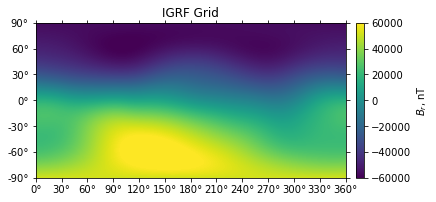

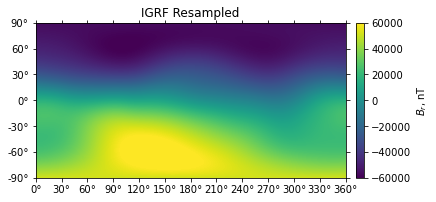

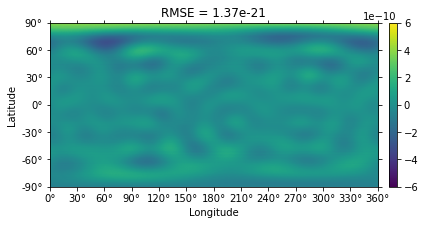

In [36]:
clim =[-60000, 60000]
climSmall = [-6e-10, 6e-10]

igrfG.plot_rad(title='IGRF Grid', cmap_limits=clim)
igrfLSG.plot_rad(title='IGRF Resampled', cmap_limits=clim)
igrfRes = igrfG.rad - igrfLSG.rad
igrfRes.plot(title='RMSE = '+str('{:0.2e}'.format(igrfLSCoeffs[1])), colorbar='right', cmap_limits=climSmall)

About the LS inversion:
Uses LAPACK routine DGELS